# Text Classification with IMDB Movie Reviews from TensorFlow Docs


This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem. 

This notebook uses tf.keras, a high-level API to build and train models in TensorFlow. 

We have used IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. 

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


## Download the IMDB dataset

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

## Explore the data 

The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

### Convert the integers back to words

Here, we create a helper function to query a dictionary object that contains the integer to string mapping:

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


Now we can use the `decode_review` function to display the text for the first review:

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Prepare the data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

* Convert the arrays into vectors of 0s and 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence  [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a `num_words * num_reviews` size matrix.

* Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape `max_length * num_reviews`. We can use an embedding layer capable of handling this shape as the first layer in our network.

Here we use the second approach. 

Since the movie reviews must be the same length, we use the pad_sequences function to standardize the lengths:

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Shows the length of the examples:

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Build the model

In this case, the input data consists of an array of word-indices. The labels to predict are either 0 or 1.

In [11]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

We could also choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Now, configure the model to use an optimizer and a loss function:

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a *validation set* by setting apart 10,000 examples from the original training data.

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 3s 196us/step - loss: 0.6920 - acc: 0.5983 - val_loss: 0.6902 - val_acc: 0.6893
Epoch 2/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.6858 - acc: 0.7147 - val_loss: 0.6807 - val_acc: 0.7326
Epoch 3/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.6709 - acc: 0.7581 - val_loss: 0.6611 - val_acc: 0.7511
Epoch 4/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.6432 - acc: 0.7679 - val_loss: 0.6307 - val_acc: 0.7698
Epoch 5/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.6039 - acc: 0.7967 - val_loss: 0.5894 - val_acc: 0.7907
Epoch 6/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.5562 - acc: 0.8173 - val_loss: 0.5442 - val_acc: 0.8063
Epoch 7/40
15000/15000 [==============================] - 0s 16us/step - loss: 0.5051 - acc: 0.8365 - val_loss: 0.4982 - val_ac

## Evaluate the model

Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [15]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 53us/step
[0.33876671977043155, 0.87196]


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

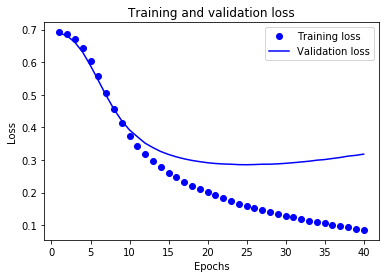

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

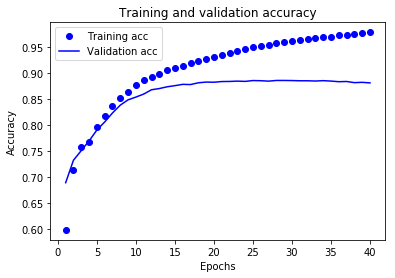

In [18]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

The training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we can prevent overfitting by simply stopping the training after twenty or so epochs.